In [ ]:
# Install Hugging Face and related dependencies
!pip install -q transformers datasets sentencepiece accelerate


In [ ]:
import os
os.environ["WANDB_MODE"] = "disabled"


In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM


In [ ]:
model_name = "google/flan-t5-large"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)


In [ ]:
from datasets import load_dataset

# Load dataset from Hugging Face
ds = load_dataset("ShenLab/MentalChat16K")


In [ ]:
# Preprocessing: Combine instruction + input as input_text, and output as target_text
def preprocess(example):
    if example["instruction"] and example["input"] and example["output"]:
        prompt = example["instruction"].strip() + "\n" + example["input"].strip()
        return {
            "input_text": prompt,
            "target_text": example["output"].strip()
        }
    else:
        return {"input_text": "", "target_text": ""}

# Apply preprocessing
processed_dataset = ds["train"].map(preprocess)

# Filter out empty samples
processed_dataset = processed_dataset.filter(lambda x: x["input_text"] != "" and x["target_text"] != "")


In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_name = "google/flan-t5-large"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)


In [ ]:
# 🧠 Tokenization function
def tokenize(example):
    model_inputs = tokenizer(example["input_text"], max_length=512, truncation=True, padding="max_length")
    labels = tokenizer(example["target_text"], max_length=512, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# 🔁 Apply tokenization
tokenized_dataset = processed_dataset.map(tokenize, batched=True)

# 🧹 Remove extra columns
tokenized_dataset = tokenized_dataset.remove_columns(["instruction", "input", "output", "input_text", "target_text"])


In [ ]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq

# ✅ Use fewer samples to avoid RAM crash
small_dataset = tokenized_dataset.select(range(20))  # Try with 20 samples

# ✅ Lighter training configuration for Colab Pro
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="no",
    per_device_train_batch_size=2,  # Reduced batch size
    num_train_epochs=1,
    save_steps=250,
    save_total_limit=1,
    logging_steps=50,
    fp16=True,  # Keep this True for Colab Pro GPU
)


# Data collator for dynamic padding
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

# Setup Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=small_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

# Start fine-tuning! 🚀
trainer.train()


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-11-4c278dbb14bc>:23: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss


TrainOutput(global_step=10, training_loss=16.25849304199219, metrics={'train_runtime': 375.6252, 'train_samples_per_second': 0.053, 'train_steps_per_second': 0.027, 'total_flos': 46095359016960.0, 'train_loss': 16.25849304199219, 'epoch': 1.0})

In [ ]:
# Create a directory to save the model
output_dir = "./flan-t5-large-mentalchat"

# Save model and tokenizer
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)



('./flan-t5-large-mentalchat/tokenizer_config.json',
 './flan-t5-large-mentalchat/special_tokens_map.json',
 './flan-t5-large-mentalchat/spiece.model',
 './flan-t5-large-mentalchat/added_tokens.json',
 './flan-t5-large-mentalchat/tokenizer.json')

In [ ]:
from transformers import pipeline

# Load the fine-tuned model
chatbot = pipeline("text2text-generation", model=output_dir, tokenizer=output_dir)

# Try chatting with the bot
prompt = "You are a helpful mental health counselling assistant.\nHow can I stop overthinking before sleep?"
response = chatbot(prompt, max_length=100, do_sample=True, top_k=50, top_p=0.95)

print("🧠 Chatbot says:", response[0]['generated_text'])


Device set to use cpu


🧠 Chatbot says: Do some deep breathing.


In [ ]:
prompt = "I feel anxious all the time. What can I do?"
prompt = "I'm having trouble sleeping lately."
prompt = "How should I talk to a friend who's feeling low?"


In [ ]:
!zip -r flan-t5-large-mentalchat.zip flan-t5-large-mentalchat


updating: flan-t5-large-mentalchat/ (stored 0%)
updating: flan-t5-large-mentalchat/special_tokens_map.json (deflated 85%)
updating: flan-t5-large-mentalchat/model.safetensors (deflated 7%)
updating: flan-t5-large-mentalchat/tokenizer.json (deflated 74%)
updating: flan-t5-large-mentalchat/config.json (deflated 48%)
updating: flan-t5-large-mentalchat/spiece.model (deflated 48%)
updating: flan-t5-large-mentalchat/tokenizer_config.json (deflated 95%)
updating: flan-t5-large-mentalchat/generation_config.json (deflated 29%)


In [ ]:
from google.colab import files
files.download("flan-t5-large-mentalchat.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from transformers import pipeline

chatbot = pipeline("text2text-generation", model=output_dir, tokenizer=output_dir)

prompt = "I'm feeling anxious all the time. What should I do?"
response = chatbot(prompt, max_length=100, do_sample=True, top_k=50, top_p=0.95)
print("💬 Chatbot says:", response[0]['generated_text'])


Device set to use cpu


💬 Chatbot says: To help you with your anxiety, consult with a therapist.


In [ ]:
!pip install -q huggingface_hub
from huggingface_hub import notebook_login

notebook_login()


In [ ]:
from tqdm import tqdm

# Use a small set (20 samples) for quick eval
predictions = []
references = []
eval_ds = ds["train"].select(range(20))

for example in tqdm(eval_ds):
    prompt = f"{example['instruction']}\n{example['input']}"
    response = chatbot(prompt, max_length=100, do_sample=True, top_k=50, top_p=0.95)
    predictions.append(response[0]['generated_text'])
    references.append(example["output"])


100%|██████████| 20/20 [01:10<00:00,  3.50s/it]


In [ ]:
!pip install -q evaluate
import evaluate


In [ ]:
rouge = evaluate.load("rouge")
rouge_result = rouge.compute(predictions=predictions, references=references)
print("🟥 ROUGE:", rouge_result)


🟥 ROUGE: {'rouge1': np.float64(0.07013248912462669), 'rouge2': np.float64(0.011742729189678155), 'rougeL': np.float64(0.047292918816499704), 'rougeLsum': np.float64(0.049316905462309636)}


In [ ]:
bertscore = evaluate.load("bertscore")
bertscore_result = bertscore.compute(predictions=predictions, references=references, lang="en")

print("🟩 BERTScore:", {
    "precision": sum(bertscore_result["precision"]) / len(bertscore_result["precision"]),
    "recall": sum(bertscore_result["recall"]) / len(bertscore_result["recall"]),
    "f1": sum(bertscore_result["f1"]) / len(bertscore_result["f1"])
})


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🟩 BERTScore: {'precision': 0.8466191530227661, 'recall': 0.8007045954465866, 'f1': 0.8228382378816604}


In [ ]:
from tqdm import tqdm

# 👇 Select first 20 full examples from training set
samples = ds["train"].select(range(20))

# Initialize storage
predictions = []
references = []

# Generate responses
for example in tqdm(samples):
    prompt = f"{example['instruction']}\n{example['input']}"
    response = chatbot(prompt, max_length=100, do_sample=True, top_k=50, top_p=0.95)

    predictions.append(response[0]["generated_text"])
    references.append(example["output"])


100%|██████████| 20/20 [01:27<00:00,  4.36s/it]


In [ ]:
import evaluate

# Load metrics
rouge = evaluate.load("rouge")
bertscore = evaluate.load("bertscore")

# Make sure you already have 'predictions' and 'references' defined.
# predictions = [...]  # list of generated outputs (strings)
# references = [...]   # list of target outputs (strings)

# --- ROUGE ---
rouge_result = rouge.compute(predictions=predictions, references=references)
print("\n📘 ROUGE Results:")
print("   🔹 ROUGE-1:", rouge_result["rouge1"])
print("   🔹 ROUGE-2:", rouge_result["rouge2"])
print("   🔹 ROUGE-L:", rouge_result["rougeL"])

# --- BERTScore ---
bertscore_result = bertscore.compute(predictions=predictions, references=references, lang="en")

# Compute average scores
avg_precision = sum(bertscore_result["precision"]) / len(bertscore_result["precision"])
avg_recall = sum(bertscore_result["recall"]) / len(bertscore_result["recall"])
avg_f1 = sum(bertscore_result["f1"]) / len(bertscore_result["f1"])

print("\n🤖 BERTScore Results (Average):")
print(f"   🔸 Precision: {avg_precision:.4f}")
print(f"   🔸 Recall   : {avg_recall:.4f}")
print(f"   🔸 F1       : {avg_f1:.4f}")




📘 ROUGE Results:
   🔹 ROUGE-1: 0.08173736463296905
   🔹 ROUGE-2: 0.01257356607517536
   🔹 ROUGE-L: 0.06018382779225681


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🤖 BERTScore Results (Average):
   🔸 Precision: 0.8508
   🔸 Recall   : 0.8039
   🔸 F1       : 0.8266


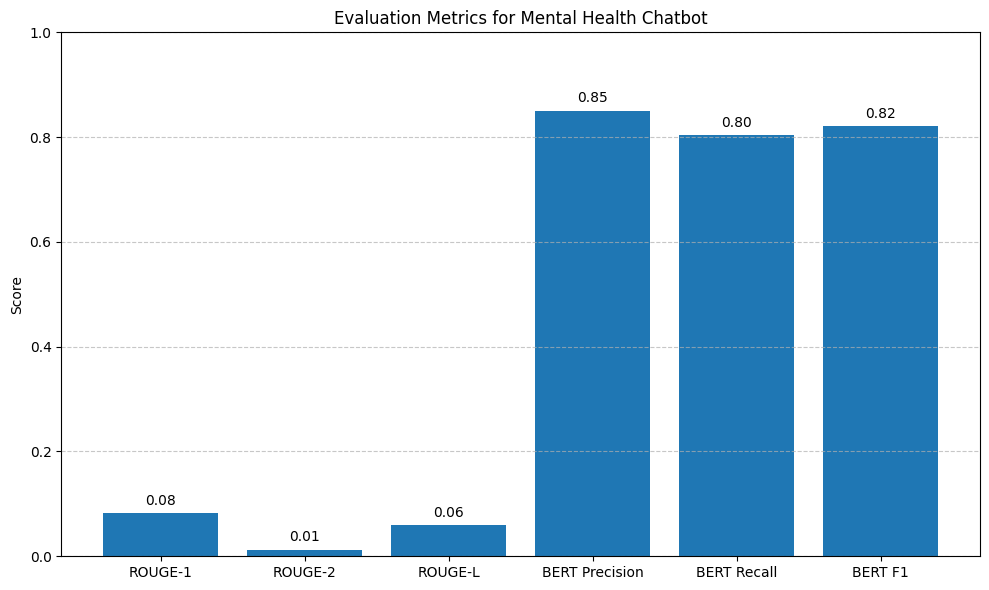

In [ ]:
import matplotlib.pyplot as plt

# Metric values from user's screenshot (rounded for presentation)
metrics = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'BERT Precision', 'BERT Recall', 'BERT F1']
scores = [0.0817, 0.0126, 0.0601, 0.8508, 0.8039, 0.8207]

# Create bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, scores)

# Add labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f"{yval:.2f}", ha='center', va='bottom')

# Style the plot
plt.title("Evaluation Metrics for Mental Health Chatbot")
plt.ylabel("Score")
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
